# Using Brain-Computer Interfaces for Emotion Detection with EEG Signal Processing and Classification

### Introduction to EEG (Electroencephalography)

An electroencephalogram (EEG) is a recording of the brain activity measured by electrodes. EEG signals were first recorded in 1924 by Hans Berger, an incredible discovery that has lead to an area of research that is still being heavily researched today with a lot of unknowns. The collection of EEG signals is non-invasive and the electrodes are placed on the scalp with gel or paste. The most common use of EEG signals for medical reasons include Epilepsy research and sleep studies. They are also used to discover brain injuries, brain inflammation, and strokes. 

Unfortunately, EEG signals have poor spatial resolution (about cm2 from the scalp) resulting in intense interpretation to understand what areas of the brain are activated by a particular response.

### Introduction to Dataset

The dataset was created by Queen Mary University of London and can be accessed at https://www.eecs.qmul.ac.uk/mmv/datasets/deap/index.html. The dataset is open for public use and requires signing a release form; therefore the dataset cannot be accessed through this github repository.<br>

The dataset consists of:<br><br>
32 Participants<br>
40 Channels (The first 32 channels are EEG)<br>
40 One-minute videos<br>
Labels: Valence, Arousal, Dominance, Liking, Familiarity, Order<br>
EEG Channel Names- 'Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz','Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2'<br>


### Project Motivation

### OSEMN Methodology

This project will be following the data science O.S.E.M.N Methodology.<br><br>
1. O — Obtaining the data<br>
&emsp;&emsp;1.1 Import Data<br>
&emsp;&emsp;1.2 Initial Data Exploration<br><br>
2. S — Scrubbing & Cleaning the data<br>
&emsp;&emsp;2.1 Marking Bad Channels<br>
&emsp;&emsp;2.2 Filtering bandpass<br>
&emsp;&emsp;2.3 Detecting Artifacts<br>
&emsp;&emsp;2.4 Eliminating Artifacts<br><br>
3. E — Exploring the data<br>
&emsp;&emsp;3.1 Finding Epochs<br>
&emsp;&emsp;3.2 Rejecting Epochs<br>
&emsp;&emsp;3.3 Creating DataFrame<br><br>
4. M — Modeling the data<br>
&emsp;&emsp;4.1 K Nearest Neighbors<br>
&emsp;&emsp;4.2 K Nearest Neighbors - Using best K<br>
&emsp;&emsp;4.3 Decision Tree Classifier<br>
&emsp;&emsp;4.4 Bag of Trees<br>
&emsp;&emsp;4.5 Grid Search- Decision Tree Classifier<br>
&emsp;&emsp;4.6 Random Forest Classifier<br>
&emsp;&emsp;4.7 Grid Search- Random Forest Classifier<br><br>
5. N — Interpreting the data<br>
&emsp;&emsp;5.1 Conclusions<br>
&emsp;&emsp;5.2 Moving Forward

### Visualizations and Signal Processing Python Library

## Import Libraries

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.axes_grid1 import (make_axes_locatable, ImageGrid,
                                     inset_locator)

from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn import tree
from sklearn.svm import SVC

import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mpl_toolkits.mplot3d import Axes3D  # noqa
import os
import pickle
# import xgboost as xgb

import random

mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

# 1. Obtain the Data

## 1.1 Import Data

In [139]:
# Import Participants Ratings Data for later
df_ratings = pd.read_csv('participant_ratings.csv')

In [140]:
!ls data_original

s01.bdf s04.bdf s08.bdf s12.bdf s16.bdf s20.bdf s24.bdf s28.bdf s32.bdf
s01.edf s05.bdf s09.bdf s13.bdf s17.bdf s21.bdf s25.bdf s29.bdf
s02.bdf s06.bdf s10.bdf s14.bdf s18.bdf s22.bdf s26.bdf s30.bdf
s03.bdf s07.bdf s11.bdf s15.bdf s19.bdf s23.bdf s27.bdf s31.bdf


There are 32 participant files with EEG data collection but for this project only the first file will be analyzed.

In [141]:
data_path = os.path.abspath("data_original")
data_path

'/Users/rosegold/Desktop/alllessons/Capstone/dsc-capstone-project-v2-online-ds-sp-000/data_original'

In [142]:
s01_raw_file = os.path.join(data_path, 's01.bdf')
s01_raw_file

'/Users/rosegold/Desktop/alllessons/Capstone/dsc-capstone-project-v2-online-ds-sp-000/data_original/s01.bdf'

In [143]:
raw = mne.io.read_raw_bdf(s01_raw_file, preload=True, stim_channel='auto', verbose=False)
raw

<RawEDF | s01.bdf, 48 x 1980928 (3869.0 s), ~725.5 MB, data loaded>

## 1.2 Data Exploration

## Sensor Locations

Electrodes, which are small metal disks, are placed strategically on the scalp according to the 10/20 rule of placement. The placement of these electrodes are measured according to fixed locations on the subject's head. Below we can see the sensor locations used for the Biosemi system used in this dataset's experiment. The Biosemi system in this experiment was a 32-channel system that is used in research settings and not for medical usage. <br>
The even numbers refer to the right side of the head and the odd numbers refer to the left side. The naming conventions of the sensors relies on the location of the sensor:<br><br>
F - Frontal lobe<br>
T - Temporal lobe<br>
C - Central lobe<br>
P - Parietal lobe<br>
O - Occipital lobe<br>

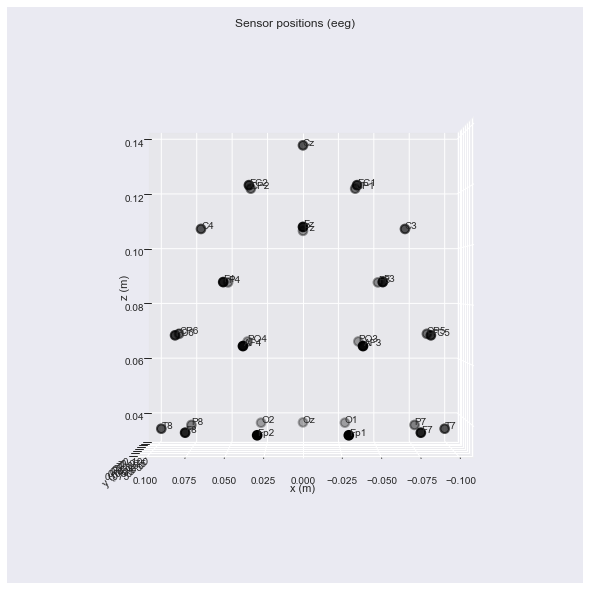

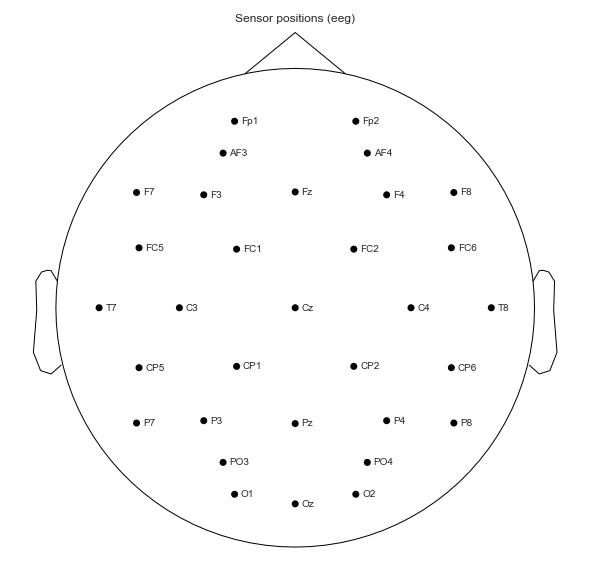

In [144]:
# Plotting the sensors in 3D and diagramatically on the head
plot_sensors = mne.channels.make_standard_montage('biosemi32')
plt.rcParams["figure.figsize"] = [8,8]
fig = plot_sensors.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)
plot_sensors.plot(kind='topomap', show_names=True);

As we can see, the Raw EEG data plotted below does not give a lot of information from first glance because it needs to be processed. 

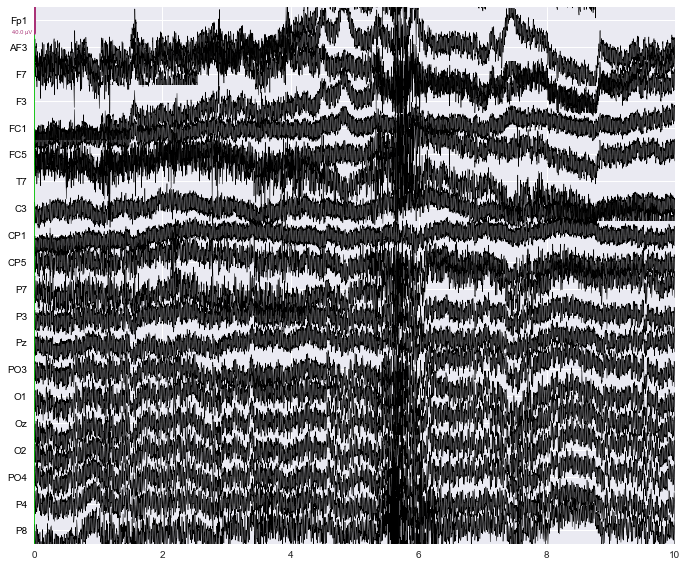

In [145]:
#Plotting raw eeg signals
plt.rcParams["figure.figsize"] = [10,8]
mne.io.Raw.plot(self=raw, show_scrollbars=False);

In [146]:
# Checking info for channel names, frequency
info = raw.info
print(raw)
print(raw.info)

<RawEDF | s01.bdf, 48 x 1980928 (3869.0 s), ~725.5 MB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 47 EEG, 1 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2010-07-01 10:00:16 UTC
 nchan: 48
 projs: []
 sfreq: 512.0 Hz
>


In [147]:
# Checking Dictionary keys
print(info.keys())
print()  # insert a blank line
print(info['ch_names'])

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp', 'Status']


In [148]:
# Checking keys for the channels
print(info['chs'])

[{'cal': 1.0, 'logno': 1, 'scanno': 1, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'Fp1', 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'loc': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'cal': 1.0, 'logno': 2, 'scanno': 2, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'AF3', 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'loc': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'cal': 1.0, 'logno': 3, 'scanno': 3, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'F7', 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'loc': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'cal': 1.0, 'logno': 4, 'scanno': 4, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'F3', 'unit': 107 (FIFF_UNIT_V)

In [149]:
# Confirming EEG channels
eeg_ch = mne.pick_channels(info['ch_names'], include=['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 
                                                   'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 
                                                   'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz'])
print(eeg_ch)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


# 2. Scrubbing the Data

## 2.1 Pre-Processing Steps

1. Marking Bad Channels<br>
2. Filtering data through desired passband
3. Removing Artifacts

The purpose of preprocessing signals is to improve the signal-to-noise ratio as well as detecting experimental effects. This is done with band-pass filtering (this passes frequencies within a certain range while rejecting frequences outside of that range). Also during preprocessing, dead channels are dropped and artifacts are removed.

### Marking Bad Channels

It is important to mark bad channels, that is channels that are malfunctioning and not showing any signal, in order to exclude them from the analysis of the signals.

<ipython-input-150-4583ced78f02>:3: UserWarning: Infinite value in PSD for channel GSR2.
These channels might be dead.
  raw.plot_psd(tmax=60., average=False)
<ipython-input-150-4583ced78f02>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmax=60., average=False)


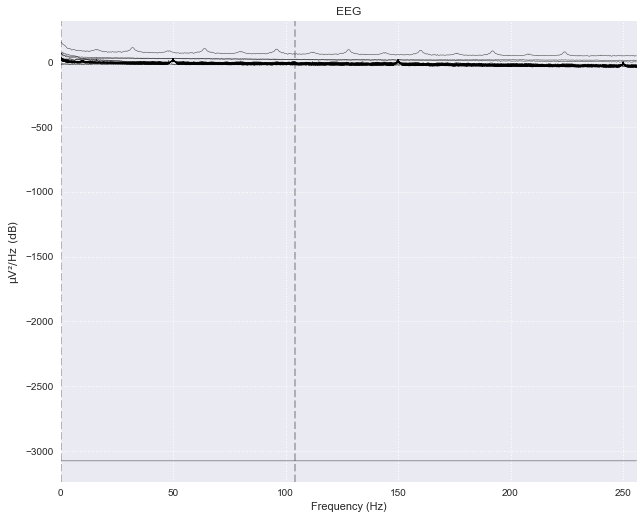

<RawEDF | s01.bdf, 48 x 1980928 (3869.0 s), ~725.5 MB, data loaded>

In [150]:
# Plotting the power spectral density of all channels
plt.rcParams["figure.figsize"] = [10,8]
raw.plot_psd(tmax=60., average=False)
raw.notch_filter(np.arange(60, 181, 60), fir_design='firwin')

<ipython-input-151-96a3c655f95e>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=30);


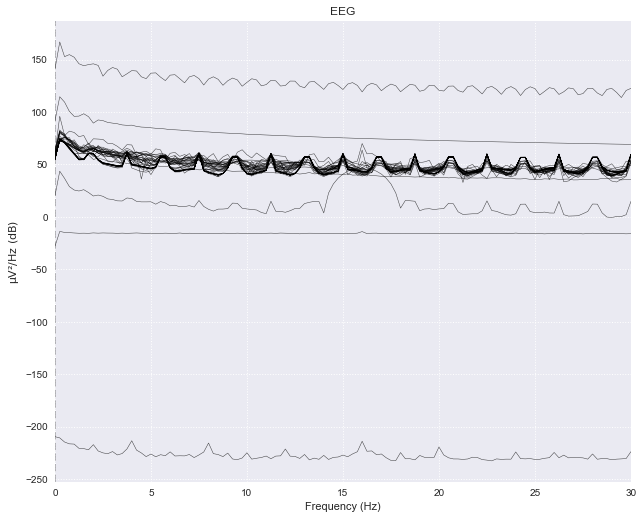

In [151]:
# Visualizing other channels
plt.rcParams["figure.figsize"] = [10,8]
raw.plot_psd(fmax=30);

We can see in the above plot that there is at least one bad channel. The error message tells us that the channel is GSR2. We will mark this as a bad channel and redo the plot to see if we can see the other channels better. We also know from the original dataset description that channels "Erg1" and "Erg2" are also not used channels so we will mark them as bad as well.

In [152]:
raw.info['bads'] = ['GSR2', 'Erg1', 'Erg2']

<ipython-input-153-f46013c2213c>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=30, picks='eeg');


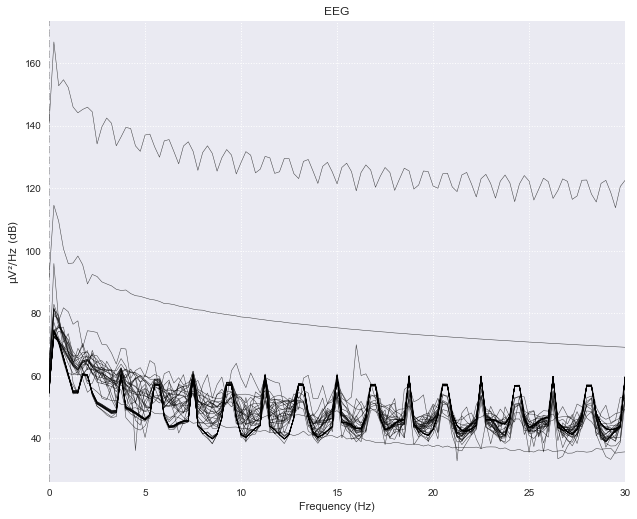

In [153]:
plt.rcParams["figure.figsize"] = [10,8]
raw.plot_psd(fmax=30, picks='eeg');

We can see now the unused channels are not included anymore. We also know there are other non-EEG channels (for example, galvanic skin response) in the dataset so we will exclude those as well since we won't be using them in the models.

In [154]:
raw.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 
'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp'])

<RawEDF | s01.bdf, 33 x 1980928 (3869.0 s), ~498.8 MB, data loaded>

Now that we have identified all of the unused and non-EEG channels, we can set the montage. This will give a location to the sensors and refer them to the system the data was collected with (Biosemi32).

<ipython-input-155-f46013c2213c>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=30, picks='eeg');


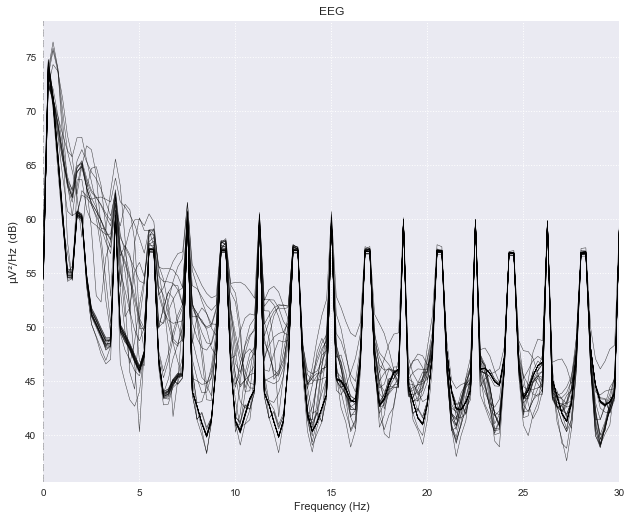

In [155]:
plt.rcParams["figure.figsize"] = [10,8]
raw.plot_psd(fmax=30, picks='eeg');

In [156]:
# Setting montage
raw = raw.copy().set_montage('biosemi32')

### Filtering Data through bandpass

In [157]:
# # Cut off frequency at 30hz
raw.filter(1,30, method='iir')

<RawEDF | s01.bdf, 33 x 1980928 (3869.0 s), ~498.8 MB, data loaded>

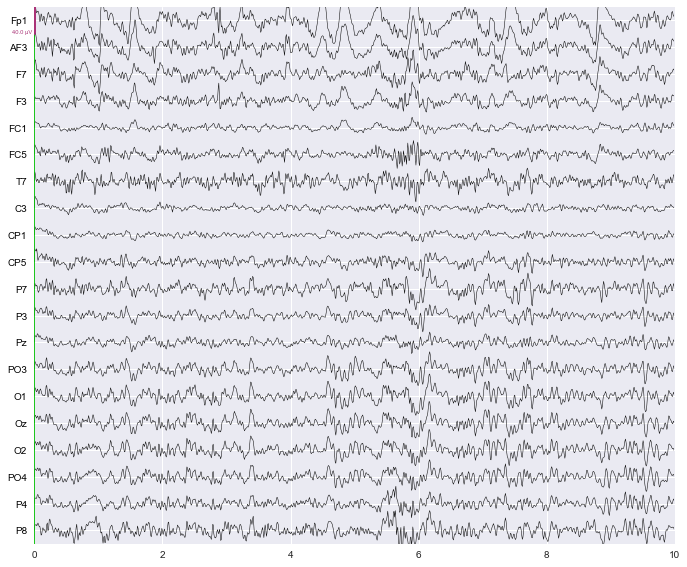

In [158]:
# #Plotting raw eeg signals
plt.rcParams["figure.figsize"] = [10,8]
mne.io.Raw.plot(self=raw, block=True, show_scrollbars=False);

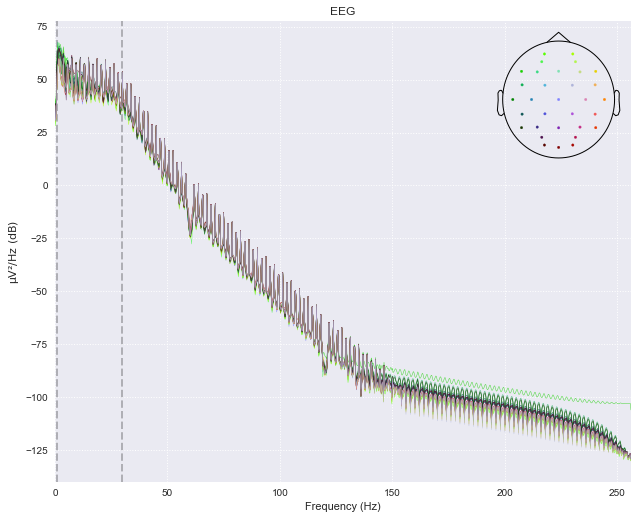

In [159]:
# Plotting the power spectral density
filt_raw = raw.copy()
plt.rcParams["figure.figsize"] = [10,8]
raw.plot_psd(picks='eeg');

We can see the low pass filter successfully has a cutoff of 30Hz to remove the impact of higher frequencies.

### Power Spectral Density

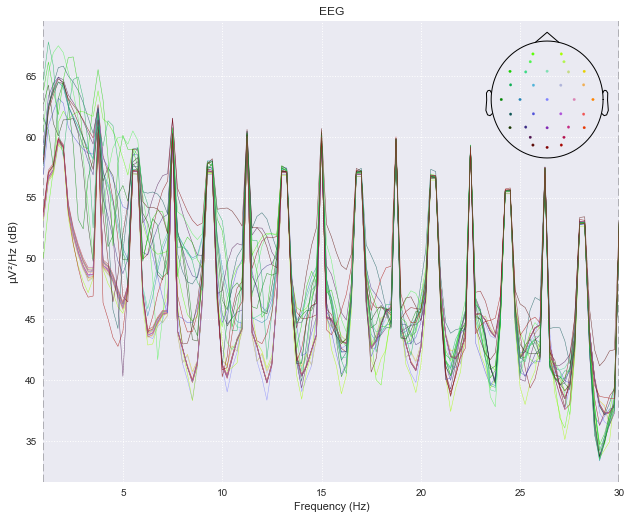

In [160]:
# Zoom of cutoff frequency
plt.rcParams["figure.figsize"] = [10,8]
raw.plot_psd(fmin=1, fmax=30);

## Visualizing Artifacts

It is important to visualize and observe the artifacts in the data before deciding which method to choose for repairing the artifacts. There are three types of artifacts that disturb EEG data. These include environmental (power lines, doors slamming, elevator noises, cell phones, air conditioning, etc), instrumentation (poor scalp connection, electromagnetic interference), and biological artifacts (heartbeats, blinking, swallowing).<br>

First we will remove the SSP (Signal Space Projection) projectors from the data. This is a matrix multiplication that reduces the rank of the data by projecting it to a lower dimensional subspace.

In [162]:
# Setting aside SSP Projectors in a separate variable and deleting them
ssp_projectors = raw.info['projs']
raw.del_proj()

<RawEDF | s01.bdf, 33 x 1980928 (3869.0 s), ~498.8 MB, data loaded>

Using our basic plot, we can observe low frequency drifts. Below we do not observe any noticable drifts and therefore do not need to perform a high pass.

<Figure size 36000x28800 with 0 Axes>

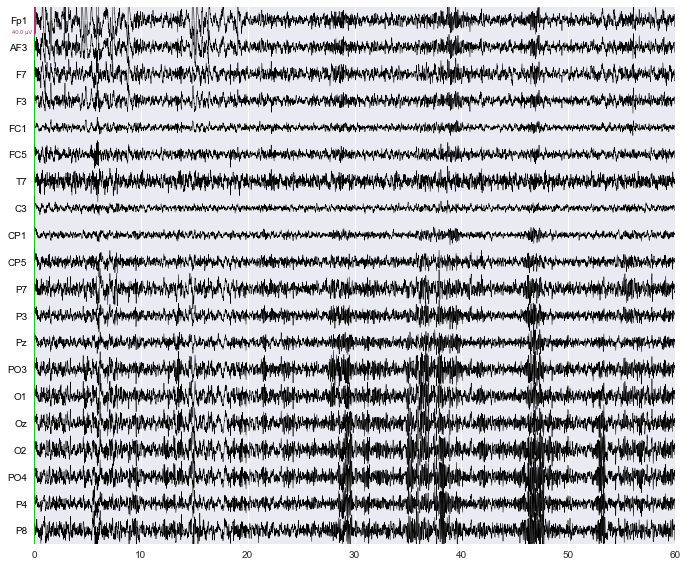

In [163]:
# Plotting and Observing Low Frequency Drifts and Blinks
plt.rcParams["figure.figsize"] = [10,8]
fig = plt.figure(figsize=(500, 400))
raw.plot(duration=60, remove_dc=False, show_scrollbars=False);

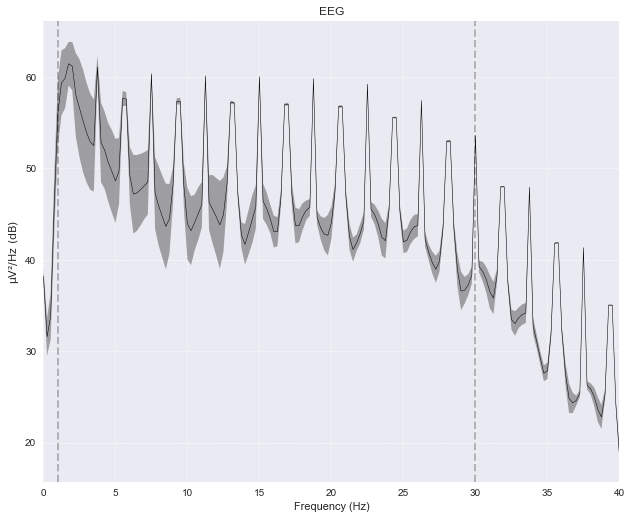

In [164]:
# Checking For Power Line Disturbances
plt.rcParams["figure.figsize"] = [10,8]
fig = raw.plot_psd(tmax=np.inf, fmax=40, average=True)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True);

## Repairing Artifacts with ICA

It is important to detect the artifacts (ocular and heartbeats) in order to determine if they are significant enough to need to be repaired and to also determine which tool to use to repair them. We will be using the Independent Component Analysis (ICA) which attempts to decompose a multivariate signal into independent non-Gaussian signals.

In [165]:
ica = mne.preprocessing.ICA(n_components=32, random_state=97, max_iter=800)
ica.fit(filt_raw)

<ICA | raw data decomposition, fit (fastica): 1980928 samples, 32 components, channels used: "eeg">

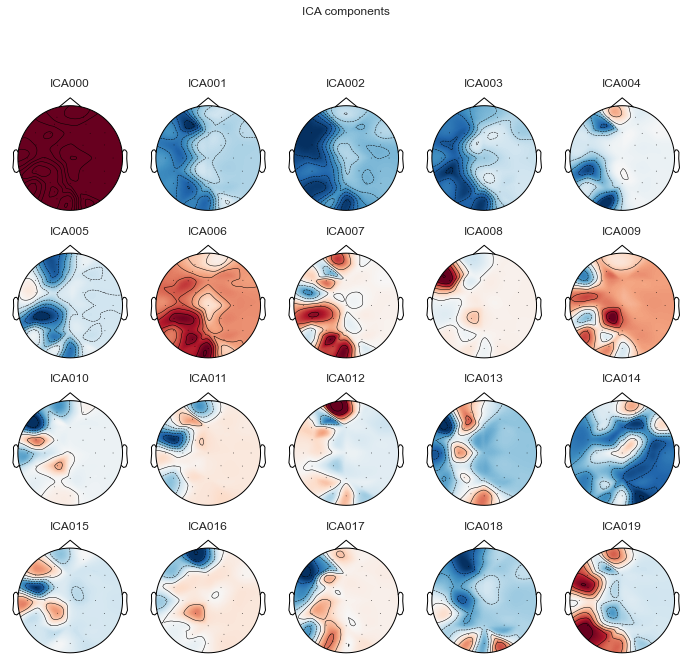

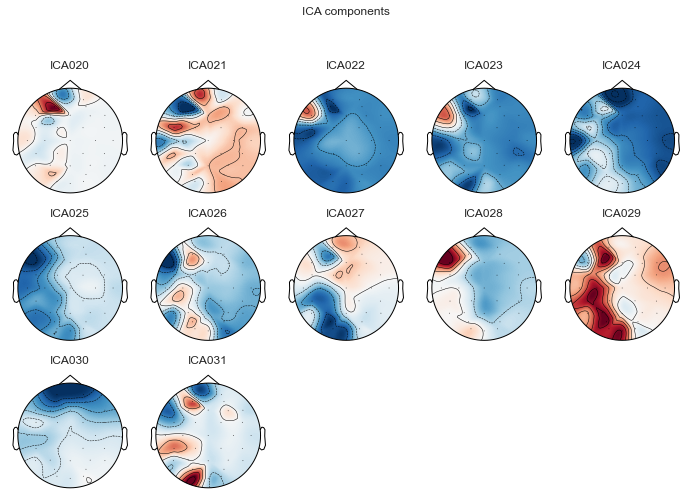

[<Figure size 702x678.24 with 20 Axes>, <Figure size 702x508.68 with 12 Axes>]

In [166]:
# Plotting Scalp Field Distribution of each component
ica.plot_components()

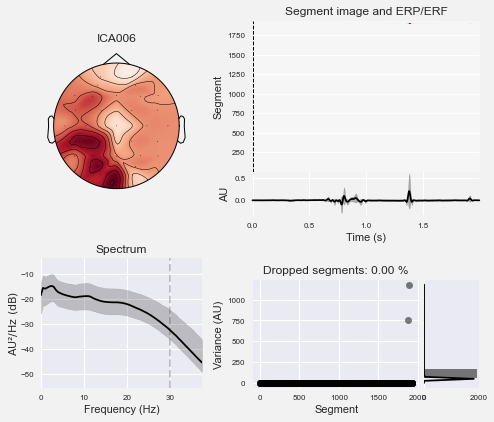

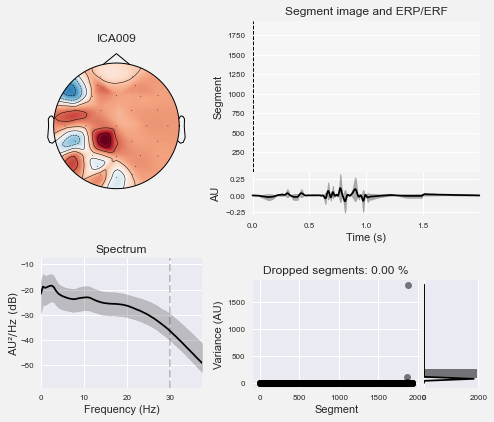

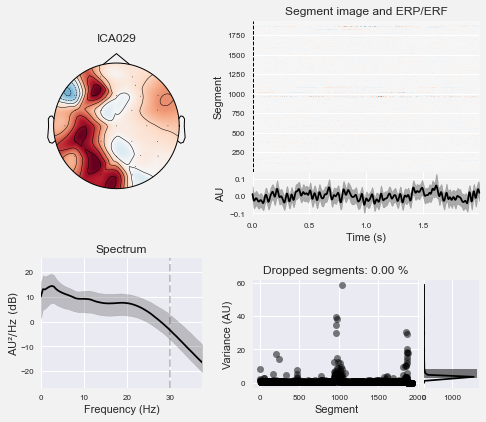

In [167]:
ica.exclude = [6,9,29]  
ica.plot_properties(filt_raw, picks=ica.exclude);

In [168]:
# ica.plot_sources(filt_raw, show_scrollbars=False);

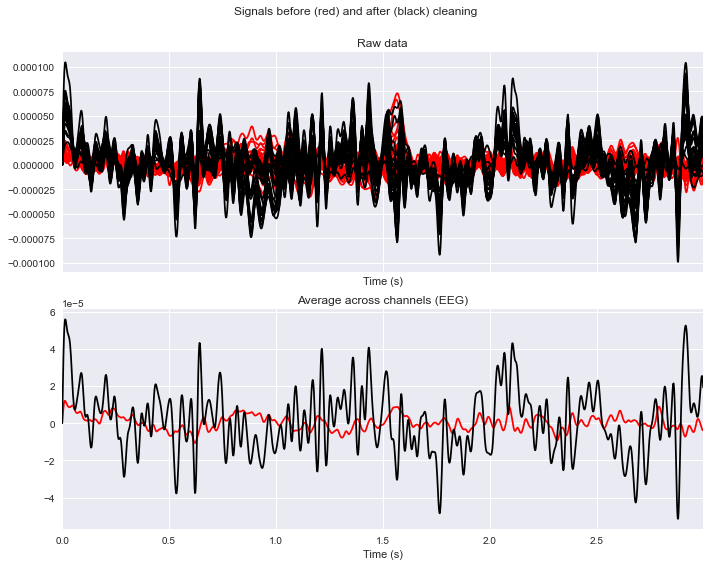

In [169]:
ica.plot_overlay(filt_raw, picks='eeg');

## Finding Events and Epochs

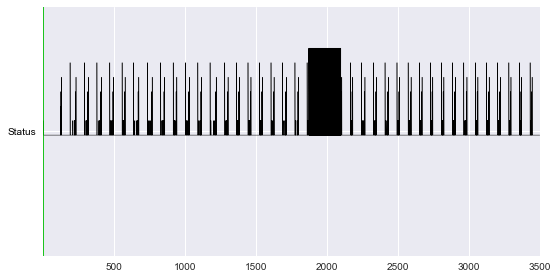

In [170]:
# Plotting pulses of the status channel showing event markers
plt.rcParams["figure.figsize"] = [8,4]
raw.copy().pick_types(stim=True).plot(start=1, duration=3500, show_scrollbars=False);

In [171]:
# # Finding the events
events = mne.find_events(raw, stim_channel='Status', initial_event=True)
# min_duration=59
print(events[:10])

[[     0      0  65536]
 [  1960      0      1]
 [  1972      0      1]
 [ 63424      0      2]
 [ 65045      0      3]
 [ 67621      0      4]
 [ 98407      0      5]
 [108034      0      1]
 [112892      0      1]
 [115092      0      1]]


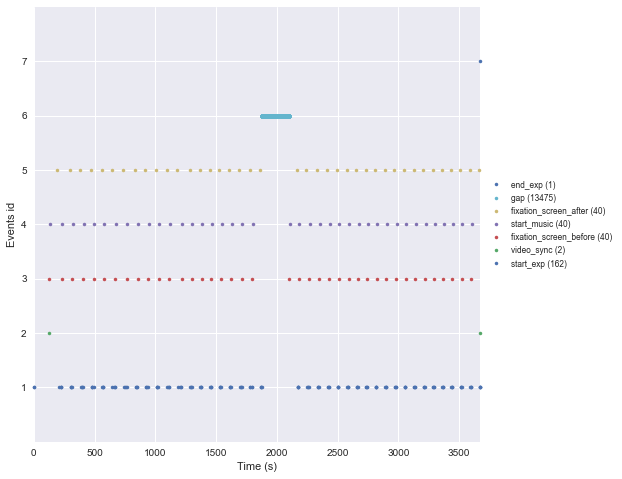

In [172]:
# Mapping events to event type
plt.rcParams["figure.figsize"] = [10,8]
event_dict = {'start_exp': 1, 'video_sync': 2, 'fixation_screen_before': 3,
              'start_music': 4, 'fixation_screen_after': 5, 'gap': 6, 'end_exp': 7}
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_dict)
# Space for Legend
fig.subplots_adjust(right=1);

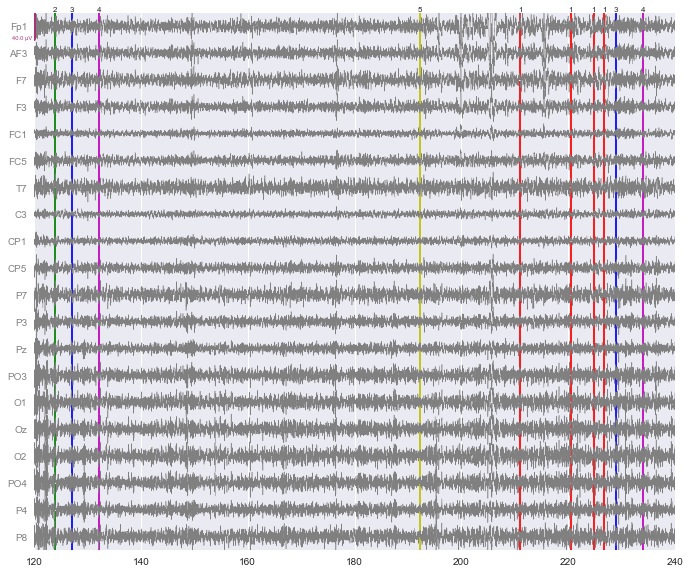

In [173]:
# Plotting events and raw data together
plt.rcParams["figure.figsize"] = [10,8]
raw.plot(events=events, start=120, show_scrollbars=False, duration=120, color='gray',
         event_color={1: 'r', 2: 'g', 3: 'b', 4: 'm', 5: 'y', 7: 'k'});

This graph below indicating percentage of epochs rejected makes sense because the frontal sensors usually have the strongest eye blink artifacts since their location is closest to the eye.

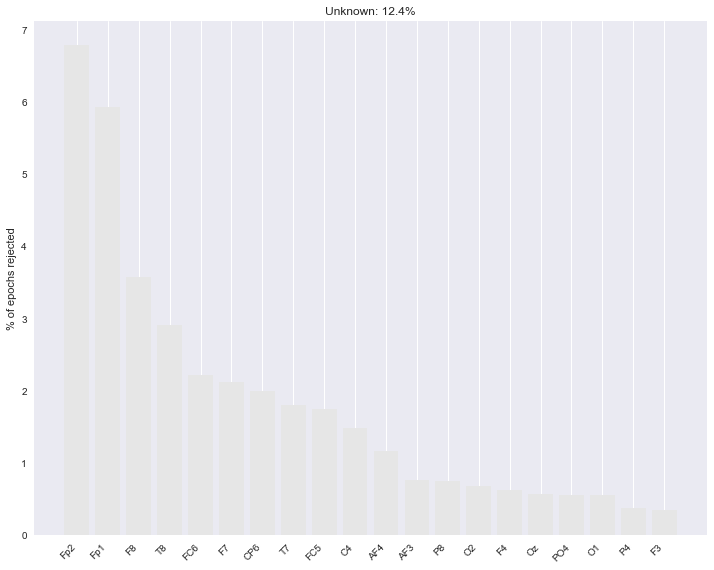

In [174]:
# We can reject eye blink artifacts based on a signal amplitude threshold 
reject_criteria = dict(eeg=100e-6)       # 100 µV max
flat_criteria = dict(eeg=1e-6)           # 1 µV min

epochs = mne.Epochs(raw, events, tmin=-0.2, tmax=0.5, reject_tmax=0,
                    reject=reject_criteria, flat=flat_criteria,
                    reject_by_annotation=False, preload=True)
epochs.plot_drop_log();

In [175]:
df_epochs = epochs.to_data_frame()
df_epochs.tail(25)
df_epochs['Status'].value_counts()

6.0    2904958
0.0    1420031
1.0       2027
3.0        236
5.0        235
4.0        234
2.0         18
7.0          6
Name: Status, dtype: int64

In [176]:
# Rejecting bad data spans/ epochs
evoked = epochs.average() 

In the chart below, we can see how the eyeblink artifacts manifest across the different channels.

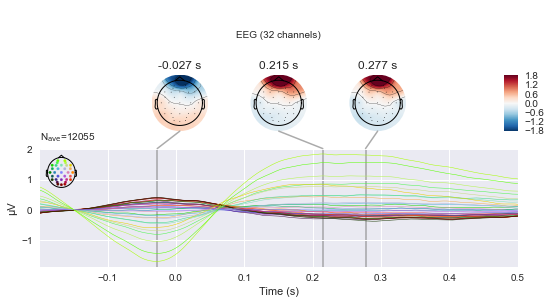

In [177]:
plt.rcParams["figure.figsize"] = [12,10]
evoked.apply_baseline(baseline=(None, -0.1))
evoked.plot_joint();

In [178]:
# Computing Noise-Covariance Matrix
# Weighs channels correctly in calculations and provides information about human or environmental noise sources.
cov = mne.compute_covariance(epochs, method='auto') 
print(cov)

<Covariance | size : 32 x 32, n_samples : 4327744, data : [[ 4.65645623e-10  2.81651478e-10  1.57272102e-10 ...  4.37727703e-10
   1.26909771e-10 -4.29164047e-12]
 [ 2.81651478e-10  1.87867599e-10  1.08548177e-10 ...  2.59959123e-10
   8.26729794e-11 -2.56717748e-12]
 [ 1.57272102e-10  1.08548177e-10  1.71711680e-10 ...  7.29753412e-11
   2.61213296e-11 -1.10070258e-11]
 ...
 [ 4.37727703e-10  2.59959123e-10  7.29753412e-11 ...  5.30387166e-10
   1.50605766e-10  1.12262053e-11]
 [ 1.26909771e-10  8.26729794e-11  2.61213296e-11 ...  1.50605766e-10
   5.78557906e-11  6.29040977e-12]
 [-4.29164047e-12 -2.56717748e-12 -1.10070258e-11 ...  1.12262053e-11
   6.29040977e-12  9.18366162e-12]]>


## Converting data to a DataFrame

In [179]:
df_evoked = epochs.to_data_frame()
# df_evoked['Status'].value_counts()
df_evoked.head()

time condition  epoch       Fp1       AF3        F7        F3       FC1  \
0  -199         1      1 -2.708220  2.326571 -6.232052  1.332547  4.110631   
1  -197         1      1 -3.011927  0.905673 -6.745394  0.032147  3.364287   
2  -195         1      1 -3.186635 -0.586539 -7.079307 -1.171824  2.564948   
3  -193         1      1 -3.199263 -2.015930 -7.184918 -2.164053  1.794102   
4  -191         1      1 -3.026201 -3.244077 -7.014528 -2.835828  1.135742   

        FC5        T7  ...         T8       FC6       FC2        F4        F8  \
0 -0.067699  1.287904  ...  -9.158784 -4.095052  4.381588  1.706035 -2.616056   
1 -0.531334 -0.597561  ... -10.249065 -4.057563  4.188233  1.417173 -3.001836   
2 -0.919068 -2.512059  ... -10.818706 -3.795538  3.866061  1.134233 -3.285446   
3 -1.178621 -4.264002  ... -10.798149 -3.312383  3.444489  0.901718 -3.389365   
4 -1.254616 -5.678559  ... -10.169113 -2.625475  2.958838  0.760220 -3.250841   

        AF4       Fp2        Fz        Cz  Status  
0  2.204621 -1.755249  5.450078  3.560951     0.0  
1  1.507132 -2.485355  4.708295  3.968949     0.0  
2  0.817411 -3.090428  3.935405  4.273480     0.0  
3  0.214690 -3.485581  3.219326  4.473386     0.0  
4 -0.228159 -3.602749  2.642141  4.573201     0.0  

[5 rows x 36 columns]

In [180]:
df = raw.to_data_frame()
df.head()

time        Fp1        AF3         F7        F3       FC1        FC5  \
0     0   0.012820   0.009747   0.010967 -0.007414 -0.012100  -0.012226   
1     2   6.114630   4.779327   5.071295  1.854329  2.480849   4.164769   
2     4  11.786571   9.305883   9.820955  3.529193  4.780216   7.996951   
3     6  16.656937  13.368811  13.990941  4.861045  6.721752  11.191136   
4     8  20.459850  16.791039  17.387514  5.749127  8.194601  13.548252   

          T7         C3        CP1  ...         T8       FC6       FC2  \
0  -0.024925  -0.023158  -0.030360  ...  -0.021207 -0.002696 -0.014839   
1   4.107830   4.842545   3.472268  ...   3.964254  1.787315  1.627585   
2   7.878844   9.353914   6.702822  ...   7.693409  3.414573  3.114581   
3  10.977751  13.205578   9.427334  ...  10.944127  4.747748  4.319896   
4  13.188314  16.181802  11.481578  ...  13.557277  5.710848  5.169380   

         F4        F8       AF4        Fp2        Fz        Cz   Status  
0 -0.009198 -0.006777  0.005460   0.015004 -0.001081 -0.005021  65536.0  
1  2.049673  2.663414  2.170550   3.132732  2.614154  1.902357  65536.0  
2  3.910691  5.113603  4.132661   6.002277  5.009792  3.632673  65536.0  
3  5.409964  7.158059  5.723367   8.414153  7.001807  5.040174  65536.0  
4  6.444654  8.672681  6.836502  10.228926  8.470316  6.035229  65536.0  

[5 rows x 34 columns]

In [181]:
video_start = df_evoked[(df_evoked['Status']==4)|(df_evoked['Status']==5)].copy()
video_start.head(25)

time condition  epoch        Fp1        AF3         F7         F3  \
1538     0         4      5   4.233450   5.349611   3.193610   1.958365   
1539     2         4      5   3.615495   4.922182   3.067127   1.774083   
1540     4         4      5   2.987433   4.433140   2.919764   1.509437   
1541     6         4      5   2.326279   3.841172   2.698123   1.109695   
1542     8         4      5   1.610030   3.114859   2.355221   0.536333   
1543    10         4      5   0.829720   2.245357   1.865626  -0.220394   
1897     0         5      6  -5.183944  -3.502949  -6.784003  -4.243107   
1898     2         5      6  -5.841004  -4.180484  -7.703595  -4.840781   
1899     4         5      6  -6.542460  -4.928605  -8.676578  -5.532903   
1900     6         5      6  -7.294499  -5.740318  -9.694724  -6.329638   
1901     8         5      6  -8.072911  -6.576721 -10.722096  -7.202515   
1902    10         5      6  -8.827625  -7.373432 -11.699689  -8.089164   
4051     0         4     12  11.860699   6.843056  11.095978   7.571519   
4052     2         4     12  11.273825   6.417558  10.227329   7.594403   
4053     4         4     12  10.296941   5.734081   9.066987   7.414019   
4054     6         4     12   9.011397   4.846668   7.700775   7.044438   
4055     8         4     12   7.524675   3.824938   6.228341   6.512759   
4056    10         4     12   5.949708   2.737263   4.744279   5.846402   
4410     0         5     13 -12.140280 -10.480991 -12.498838  -8.161428   
4411     2         5     13 -13.062098 -11.580307 -13.167529  -9.014476   
4412     4         5     13 -13.710487 -12.421388 -13.630196  -9.676148   
4413     6         5     13 -14.119216 -12.994914 -13.894101 -10.118828   
4414     8         5     13 -14.355611 -13.327040 -13.990217 -10.342152   
4415    10         5     13 -14.511886 -13.477240 -13.970871 -10.375823   
6564     0         4     19   0.083853   2.808121   0.870748   1.787170   

           FC1       FC5         T7  ...         T8       FC6       FC2  \
1538  1.246190  2.209381   1.779555  ...  11.360602  6.759415  2.541929   
1539  1.099853  2.356834   2.662368  ...  11.206107  7.620771  2.346861   
1540  0.916380  2.420922   3.435955  ...  10.807804  8.351733  2.057318   
1541  0.655076  2.352226   4.052636  ...  10.225498  8.906991  1.654016   
1542  0.287471  2.117133   4.485609  ...   9.541104  9.263387  1.137263   
1543 -0.191785  1.709133   4.740022  ...   8.856686  9.425891  0.531688   
1897  0.103098 -4.906294  -1.805227  ...  -4.160696 -2.028255 -0.317208   
1898  0.005534 -5.672365  -2.545956  ...  -3.832313 -0.842972  0.725736   
1899 -0.158166 -6.435407  -3.125216  ...  -3.548327  0.219547  1.727455   
1900 -0.394327 -7.192237  -3.543112  ...  -3.325256  1.094245  2.632062   
1901 -0.682480 -7.917386  -3.804079  ...  -3.164680  1.745747  3.410338   
1902 -0.979742 -8.567539  -3.919180  ...  -3.056820  2.166626  4.057524   
4051  0.983750  9.040025  11.371909  ...  15.087500  9.918890  2.695194   
4052  1.213509  8.714524  10.268954  ...  13.225524  8.978240  2.719100   
4053  1.380993  8.202556   8.787075  ...  11.172074  7.846254  2.610219   
4054  1.493502  7.539193   7.018130  ...   9.056298  6.615366  2.385506   
4055  1.564300  6.767907   5.072922  ...   7.011011  5.382157  2.071374   
4056  1.601359  5.927375   3.064742  ...   5.152349  4.228022  1.691543   
4410 -2.958446 -7.572682  -6.348210  ...  -2.706660 -0.393079 -1.799539   
4411 -3.594473 -8.148429  -6.874674  ...  -1.648385  0.309708 -2.089626   
4412 -4.115172 -8.633401  -7.369855  ...  -0.331171  1.237223 -2.279851   
4413 -4.475156 -9.008189  -7.847701  ...   1.195799  2.333739 -2.351863   
4414 -4.654801 -9.270475  -8.325919  ...   2.857984  3.517937 -2.316166   
4415 -4.665607 -9.438417  -8.823707  ...   4.564850  4.694462 -2.210477   
6564  0.887021  3.908052   1.221393  ...  -3.709070 -1.483478 -4.031371   

             F4         F8       AF4       Fp2        Fz        Cz  Status  
1538   5.732736   8.649074 

In [182]:
video_start['video'] = 0

In [183]:
video_number = 1
previous_status = 4
for index, col in video_start.iterrows():
    if (col['Status']==4) & (previous_status==4):
        previous_status = col['Status']
        video_start.loc[index,'video']=video_number
    elif (col['Status']==5) & (previous_status==5):
        previous_status = col['Status']
        video_start.loc[index,'video']=video_number    
    elif (col['Status']==5) & (previous_status==4):
        previous_status = col['Status']
        video_start.loc[index,'video']=video_number 
    elif (col['Status']==4) & (previous_status==5):
        previous_status = col['Status']
        video_number += 1
        video_start.loc[index,'video']=video_number

In [184]:
video_start[['time', 'Status', 'video']].tail()

time  Status  video
4325335     2     5.0     40
4325336     4     5.0     40
4325337     6     5.0     40
4325338     8     5.0     40
4325339    10     5.0     40

In [185]:
df[df['Status']==4]

time        Fp1        AF3         F7         F3       FC1  \
67621     132072   4.601056   6.476391   3.143950   2.847900  1.099428   
67622     132074   3.983101   6.048962   3.017467   2.663618  0.953091   
67623     132076   3.355039   5.559920   2.870104   2.398971  0.769618   
67624     132078   2.693885   4.967953   2.648463   1.999230  0.508314   
67625     132080   1.977636   4.241640   2.305561   1.425868  0.140709   
...          ...        ...        ...        ...        ...       ...   
1845505  3604502 -10.606875 -10.530125  -5.532329  -8.551755 -5.814124   
1845506  3604504 -12.517874 -12.176421  -7.077390 -10.093715 -6.627363   
1845507  3604506 -14.458884 -13.896977  -8.728683 -11.727236 -7.506275   
1845508  3604508 -16.370505 -15.636041 -10.443229 -13.380639 -8.402979   
1845509  3604510 -18.180476 -17.326037 -12.161097 -14.976018 -9.260197   

              FC5        T7        C3       CP1  ...         T8        FC6  \
67621    2.183137 -0.210515 -0.085886 -4.781547  ...   6.121838   3.472879   
67622    2.330591  0.672298  0.317536 -4.152279  ...   5.967343   4.334234   
67623    2.394679  1.445885  0.665013 -3.543759  ...   5.569040   5.065197   
67624    2.325983  2.062566  0.898649 -3.009659  ...   4.986735   5.620454   
67625    2.090890  2.495539  0.977890 -2.586978  ...   4.302340   5.976851   
...           ...       ...       ...       ...  ...        ...        ...   
1845505 -2.492768 -2.711353  6.390063  2.435675  ... -20.233530 -17.108522   
1845506 -3.557849 -3.312157  6.004812  2.870282  ... -20.213091 -17.357649   
1845507 -4.735252 -4.014756  5.458891  3.274387  ... -20.005073 -17.550868   
1845508 -5.990980 -4.822551  4.795417  3.661210  ... -19.613708 -17.673846   
1845509 -7.277919 -5.727504  4.066695  4.048579  ... -19.033498 -17.699397   

               FC2         F4         F8        AF4        Fp2         Fz  \
67621     2.790095   5.402813   3.821502   5.312221   4.391667   4.387860   
67622     2.595026   5.396263   4.290410   5.049028   4.146167   4.069486   
67623     2.305483   5.332553   4.595018   4.754133   3.874433   3.723882   
67624     1.902182   5.170389   4.709613   4.401604   3.552998   3.326653   
67625     1.385428   4.884235   4.631758   3.974937   3.169243   2.864299   
...            ...        ...        ...        ...        ...        ...   
1845505  -9.256651 -17.881677 -14.355788 -14.648915 -19.709534 -11.474961   
1845506  -9.720795 -18.528819 -15.559329 -15.945414 -21.042664 -12.406911   
1845507 -10.229511 -19.202505 -16.713969 -17.330581 -22.431577 -13.413593   
1845508 -10.748796 -19.884353 -17.756771 -18.746454 -23.832538 -14.455309   
1845509 -11.236242 -20.542038 -18.616567 -20.121561 -25.185587 -15.480434   

               Cz  Status  
67621   -0.590439     4.0  
67622   -0.510808     4.0  
67623   -0.487474     4.0  
67624   -0.541636     4.0  
67625   -0.674540     4.0  
...           ...     ...  
1845505 -4.665252     4.0  
1845506 -4.414163     4.0  
1845507 -4.096463     4.0  
1845508 -3.705802     4.0  
1845509 -3.235699     4.0  

[234 rows x 34 columns]

In [186]:
video_start.head()

time condition  epoch       Fp1       AF3        F7        F3       FC1  \
1538     0         4      5  4.233450  5.349611  3.193610  1.958365  1.246190   
1539     2         4      5  3.615495  4.922182  3.067127  1.774083  1.099853   
1540     4         4      5  2.987433  4.433140  2.919764  1.509437  0.916380   
1541     6         4      5  2.326279  3.841172  2.698123  1.109695  0.655076   
1542     8         4      5  1.610030  3.114859  2.355221  0.536333  0.287471   

           FC5        T7  ...       FC6       FC2        F4        F8  \
1538  2.209381  1.779555  ...  6.759415  2.541929  5.732736  8.649074   
1539  2.356834  2.662368  ...  7.620771  2.346861  5.726186  9.117982   
1540  2.420922  3.435955  ...  8.351733  2.057318  5.662475  9.422589   
1541  2.352226  4.052636  ...  8.906991  1.654016  5.500312  9.537184   
1542  2.117133  4.485609  ...  9.263387  1.137263  5.214157  9.459330   

           AF4       Fp2        Fz        Cz  Status  video  
1538  5.918710  5.936834  3.726511  0.407861     4.0      1  
1539  5.655517  5.691334  3.408137  0.487491     4.0      1  
1540  5.360623  5.419600  3.062533  0.510825     4.0      1  
1541  5.008093  5.098165  2.665304  0.456663     4.0      1  
1542  4.581427  4.714411  2.202949  0.323759     4.0      1  

[5 rows x 37 columns]

The participant ratings was a survey-based dataset that aligns with the collection of EEG signals. The participants manually described their experience with each video in terms of "valence, arousal, dominance, liking and familiarity." We will map these emotions to each clip of EEG signal related to the video.

In [187]:
# Participants Ratings
df_ratings.head(41)

Participant_id  Trial  Experiment_id  Start_time  Valence  Arousal  \
0                1      1              5     1695918     6.96     3.92   
1                1      2             18     2714905     7.23     7.15   
2                1      3              4     3586768     4.94     6.01   
3                1      4             24     4493800     7.04     7.09   
4                1      5             20     5362005     8.26     7.91   
5                1      6             31     6176062     3.03     8.14   
6                1      7             40     7138735     5.10     7.12   
7                1      8             39     8081417     3.24     6.18   
8                1      9             13     8960934     1.95     3.12   
9                1     10             33     9816492     3.81     3.85   
10               1     11              6    10696693     8.27     3.92   
11               1     12             10    11559734     1.99     4.86   
12               1     13             35    12593050     2.06     8.15   
13               1     14             22    13429432     7.09     2.08   
14               1     15             15    14230827     3.17     8.08   
15               1     16             17    15040219     2.46     6.91   
16               1     17             36    15852443     2.90     6.92   
17               1     18             34    16671331     2.28     7.09   
18               1     19             14    17538704     4.18     2.24   
19               1     20             27    18394413     7.35     6.95   
20               1     21             11    21438533     2.99     2.36   
21               1     22             30    22211440     2.08     2.99   
22               1     23             29    23070480     1.36     2.27   
23               1     24              1    23886202     7.71     7.60   
24               1     25              7    24727583     7.44     3.73   
25               1     26             32    25513149     2.28     8.00   
26               1     27             12    26324041     2.71     2.77   
27               1     28             16    27096611     6.81     7.44   
28               1     29             25    27849356     8.86     7.21   
29               1     30             28    28631424     3.88     3.35   
30               1     31              8    29432485     7.32     2.55   
31               1     32              3    30256705     8.58     7.54   
32               1     33             38    31027614     3.33     7.18   
33               1     34             37    31824673     2.31     6.88   
34               1     35             19    32609406     7.17     8.00   
35               1     36              2    33358152     8.10     7.31   
36               1     37             21    34106731     9.00     7.95   
37               1     38             23    34848979     8.15     3.01   
38               1     39              9    35645376     4.04     3.29   
39               1     40             26    36420779     7.28     7.27   
40               2      1             27     9130709     4.96     5.01   

    Dominance  Liking  Familiarity  
0        7.19    6.05          4.0  
1        6.94    8.01          4.0  
2        6.12    8.06          4.0  
3        8.01    8.22          4.0  
4        7.19    8.13          1.0  
5        2.86    8.04          1.0  
6        6.17    5.97          3.0  
7        7.87    6.15          1.0  
8        2.87    6.18          1.0  
9        4.78    5.13          1.0  
10       7.00    8.03          2.0  
11       2.04    7.09          2.0  
12       8.05    5.18          1.0  
13       7.06    7.37          1.0  
14       2.91    5.04          1.0  
15       6.77    6.41          4.0  
16       6.50    3.87          1.0  
17       7.28    6.92          1.0  
18       3.04    5.04          4.0  
19       7.03    7.29          4.0  
20       3.63    6.24          1.0  
21       3.22    7.33          2.0  
22       3.00    8.14          2.0  
23     

In [188]:
df_ratings['Familiarity'] = df_ratings['Familiarity'].fillna(0)

In [189]:
df_ratings.drop(['Participant_id','Experiment_id', 'Start_time'], axis=1, inplace=True)

In [190]:
df_ratings.head()

Trial  Valence  Arousal  Dominance  Liking  Familiarity
0      1     6.96     3.92       7.19    6.05          4.0
1      2     7.23     7.15       6.94    8.01          4.0
2      3     4.94     6.01       6.12    8.06          4.0
3      4     7.04     7.09       8.01    8.22          4.0
4      5     8.26     7.91       7.19    8.13          1.0

In [191]:
df_ratings.drop(40, inplace=True)

In [192]:
df_ratings.shape

(1279, 6)

In [193]:
df_ratings.loc[:39]

Trial  Valence  Arousal  Dominance  Liking  Familiarity
0       1     6.96     3.92       7.19    6.05          4.0
1       2     7.23     7.15       6.94    8.01          4.0
2       3     4.94     6.01       6.12    8.06          4.0
3       4     7.04     7.09       8.01    8.22          4.0
4       5     8.26     7.91       7.19    8.13          1.0
5       6     3.03     8.14       2.86    8.04          1.0
6       7     5.10     7.12       6.17    5.97          3.0
7       8     3.24     6.18       7.87    6.15          1.0
8       9     1.95     3.12       2.87    6.18          1.0
9      10     3.81     3.85       4.78    5.13          1.0
10     11     8.27     3.92       7.00    8.03          2.0
11     12     1.99     4.86       2.04    7.09          2.0
12     13     2.06     8.15       8.05    5.18          1.0
13     14     7.09     2.08       7.06    7.37          1.0
14     15     3.17     8.08       2.91    5.04          1.0
15     16     2.46     6.91       6.77    6.41          4.0
16     17     2.90     6.92       6.50    3.87          1.0
17     18     2.28     7.09       7.28    6.92          1.0
18     19     4.18     2.24       3.04    5.04          4.0
19     20     7.35     6.95       7.03    7.29          4.0
20     21     2.99     2.36       3.63    6.24          1.0
21     22     2.08     2.99       3.22    7.33          2.0
22     23     1.36     2.27       3.00    8.14          2.0
23     24     7.71     7.60       6.90    7.83          5.0
24     25     7.44     3.73       7.08    7.04          2.0
25     26     2.28     8.00       3.27    3.95          4.0
26     27     2.71     2.77       3.40    7.35          1.0
27     28     6.81     7.44       8.15    7.14          3.0
28     29     8.86     7.21       8.65    7.21          2.0
29     30     3.88     3.35       4.01    7.87          1.0
30     31     7.32     2.55       6.32    5.87          4.0
31     32     8.58     7.54       9.00    7.08          5.0
32     33     3.33     7.18       6.54    6.62          1.0
33     34     2.31     6.88       3.10    6.77          1.0
34     35     7.17     8.00       8.10    6.79          4.0
35     36     8.10     7.31       7.28    8.47          2.0
36     37     9.00     7.95       8.37    7.86          2.0
37     38     8.15     3.01       7.37    7.90          1.0
38     39     4.04     3.29       3.62    5.99          5.0
39     40     7.28     7.27       7.41    8.24          3.0

In [194]:
df_merge = pd.merge(left=video_start, right=df_ratings.loc[:39], left_on='video', right_on='Trial')
df_merge

time condition  epoch       Fp1       AF3        F7        F3       FC1  \
0       0         4      5  4.233450  5.349611  3.193610  1.958365  1.246190   
1       2         4      5  3.615495  4.922182  3.067127  1.774083  1.099853   
2       4         4      5  2.987433  4.433140  2.919764  1.509437  0.916380   
3       6         4      5  2.326279  3.841172  2.698123  1.109695  0.655076   
4       8         4      5  1.610030  3.114859  2.355221  0.536333  0.287471   
..    ...       ...    ...       ...       ...       ...       ...       ...   
464     2         5  13754 -8.739101 -5.555347 -8.263405 -3.764520  1.587833   
465     4         5  13754 -8.914614 -5.769907 -7.674510 -4.083432  1.119915   
466     6         5  13754 -9.140586 -5.987668 -7.063035 -4.378659  0.597148   
467     8         5  13754 -9.387043 -6.193436 -6.438455 -4.645019  0.042475   
468    10         5  13754 -9.604279 -6.356683 -5.794503 -4.866262 -0.509806   

          FC5        T7  ...        Fz        Cz  Status  video  Trial  \
0    2.209381  1.779555  ...  3.726511  0.407861     4.0      1      1   
1    2.356834  2.662368  ...  3.408137  0.487491     4.0      1      1   
2    2.420922  3.435955  ...  3.062533  0.510825     4.0      1      1   
3    2.352226  4.052636  ...  2.665304  0.456663     4.0      1      1   
4    2.117133  4.485609  ...  2.202949  0.323759     4.0      1      1   
..        ...       ...  ...       ...       ...     ...    ...    ...   
464 -4.228858 -1.655766  ... -0.730236  2.076816     5.0     40     40   
465 -3.445914 -0.298200  ... -1.867230  1.537845     5.0     40     40   
466 -2.634489  0.941367  ... -3.099511  0.967527     5.0     40     40   
467 -1.816130  2.048653  ... -4.367208  0.415504     5.0     40     40   
468 -0.995223  3.043903  ... -5.600631 -0.069042     5.0     40     40   

     Valence  Arousal  Dominance  Liking  Familiarity  
0       6.96     3.92       7.19    6.05          4.0  
1       6.96     3.92       7.19    6.05          4.0  
2       6.96     3.92       7.19    6.05          4.0  
3       6.96     3.92       7.19    6.05          4.0  
4       6.96     3.92       7.19    6.05          4.0  
..       ...      ...        ...     ...          ...  
464     7.28     7.27       7.41    8.24          3.0  
465     7.28     7.27       7.41    8.24          3.0  
466     7.28     7.27       7.41    8.24          3.0  
467     7.28     7.27       7.41    8.24          3.0  
468     7.28     7.27       7.41    8.24          3.0  

[469 rows x 43 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a47d5a8e0>,
      dtype=object)

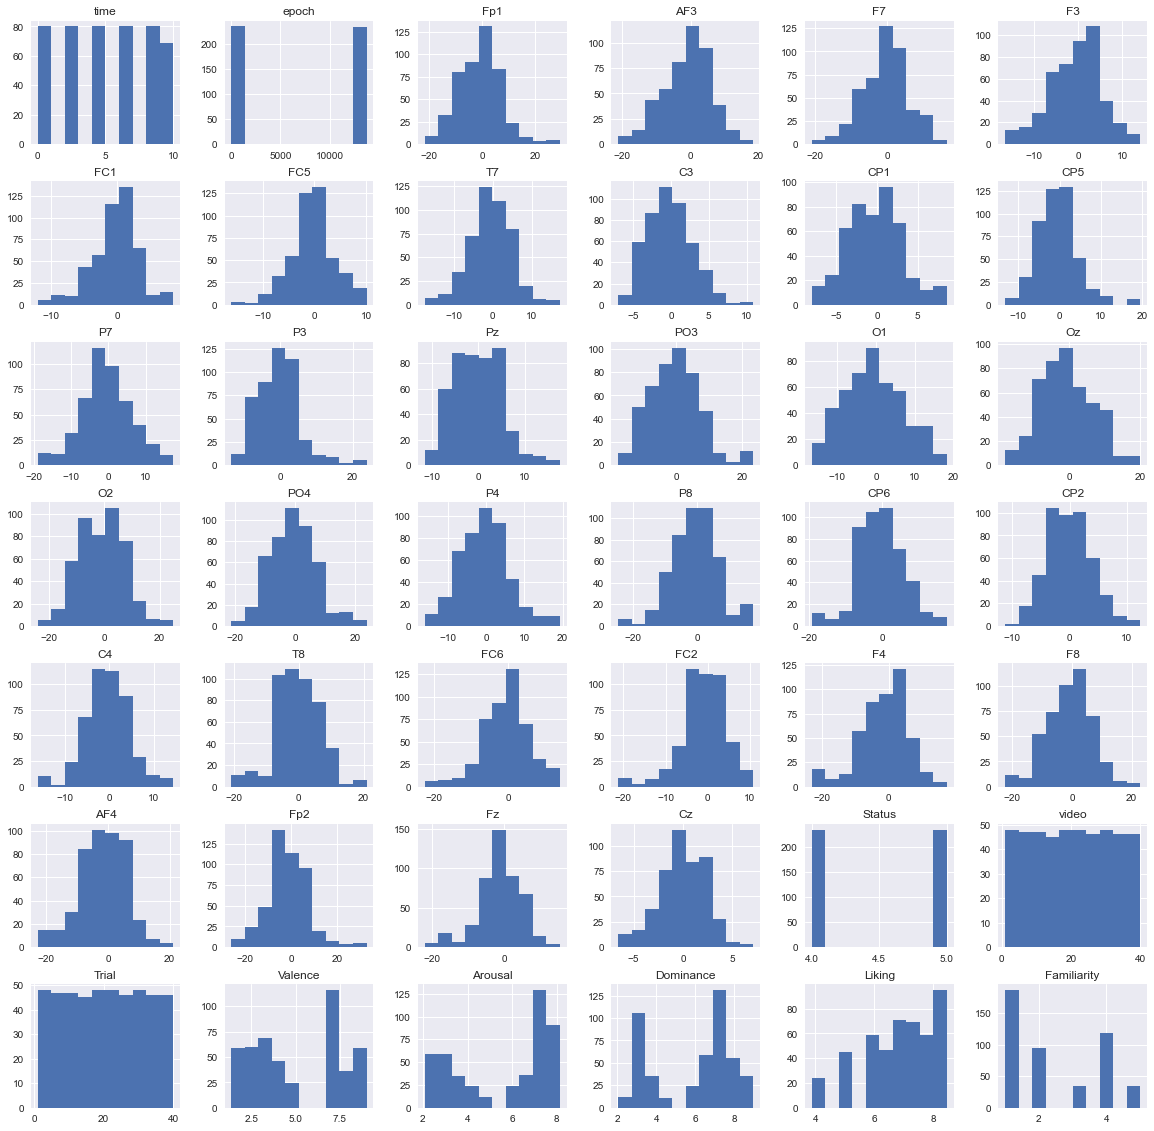

In [195]:
plt.style.use('seaborn')
df_merge.hist(bins=10, figsize=(20,20))

In [196]:
df_mean = df_merge.groupby('video').mean().describe()
df_mean

time         epoch        Fp1        AF3         F7         F3  \
count  40.000000     40.000000  40.000000  40.000000  40.000000  40.000000   
mean    4.872727   6879.501136  -0.812843  -0.954860  -0.539354  -0.585209   
std     0.238132   6894.343267   5.137780   4.500583   4.295114   3.995701   
min     4.000000      5.500000 -12.991137 -11.333052 -15.044998 -10.101576   
25%     4.886364     73.761364  -3.728088  -4.395134  -2.685842  -3.181244   
50%     5.000000   6879.500000  -1.362692  -0.830733  -0.452321  -0.622563   
75%     5.000000  13685.250000   2.653070   2.246916   1.885166   2.338078   
max     5.000000  13753.500000  14.463908   8.691244   8.810010   7.809358   

             FC1        FC5         T7         C3  ...        Fp2         Fz  \
count  40.000000  40.000000  40.000000  40.000000  ...  40.000000  40.000000   
mean   -0.284859  -0.342710  -0.538208  -0.082923  ...  -1.372423  -1.278611   
std     2.218312   2.946426   3.737029   2.194424  ...   6.125552   4.015502   
min    -4.399460 -10.616354 -13.382750  -5.191151  ... -14.523058  -9.479506   
25%    -2.251420  -1.961882  -2.204595  -1.264989  ...  -5.264223  -4.207669   
50%     0.265500  -0.125794  -0.435063  -0.362197  ...  -1.079018  -0.708940   
75%     1.281887   1.297289   1.544521   1.583870  ...   1.807969   1.476468   
max     4.071804   5.291396   7.571302   4.764004  ...  15.878250   7.075714   

              Cz     Status      Trial   Valence    Arousal  Dominance  \
count  40.000000  40.000000  40.000000  40.00000  40.000000  40.000000   
mean   -0.042756   4.501136  20.500000   5.11775   5.659750   5.902500   
std     1.433465   0.021805  11.690452   2.51712   2.179549   2.082028   
min    -2.891273   4.454545   1.000000   1.36000   2.080000   2.040000   
25%    -1.060880   4.500000  10.750000   2.85250   3.335000   3.565000   
50%     0.173137   4.500000  20.500000   4.56000   6.915000   6.835000   
75%     1.044665   4.500000  30.250000   7.32750   7.342500   7.302500   
max     2.467971   4.545455  40.000000   9.00000   8.150000   9.000000   

          Liking  Familiarity  
count  40.000000    40.000000  
mean    6.846750     2.400000  
std     1.188173     1.428645  
min     3.870000     1.000000  
25%     6.125000     1.000000  
50%     7.085000     2.000000  
75%     7.877500     4.000000  
max     8.470000     5.000000  

[8 rows x 41 columns]

In [197]:
df_mean_all = df_merge.groupby('video').mean()
df_mean_all

time         epoch        Fp1        AF3         F7         F3  \
video                                                                       
1      5.000000      5.500000  -2.180003  -0.699682  -3.265101  -2.464216   
2      5.000000     12.500000  -2.165195  -3.656526  -2.674005  -1.308776   
3      5.000000     19.500000   2.973855   6.157883   0.855346   7.809358   
4      5.000000     26.500000   3.377869   0.849569  -2.734465  -0.637639   
5      5.000000     33.500000  -1.142806   0.845387   0.062375   1.871214   
6      4.545455     40.545455   4.193792   3.022318   6.251965   4.913295   
7      5.000000     47.500000  -3.714855  -0.961783  -0.429546   0.139397   
8      5.000000     54.500000   0.764109   2.146188  -0.475095   2.413197   
9      5.000000     61.500000  -6.779047  -4.543945  -6.137288  -1.584164   
10     4.545455     68.545455   0.812267   1.627041   0.472488   2.586780   
11     5.000000     75.500000   0.036626   2.161124   2.067054   3.709423   
12     5.000000     82.500000  -1.647162  -1.958208  -0.237694  -1.498185   
13     4.545455     89.454545   3.078558   2.504292  -1.896234   0.001076   
14     4.545455     96.454545  -1.179594  -4.583728  -1.389147  -5.242573   
15     4.545455    103.545455   4.115573   2.585819   8.810010  -0.347912   
16     5.000000    110.500000  -6.759041  -7.471442  -2.725224  -5.282768   
17     5.000000    117.500000   1.731697  -1.945299  -1.774923  -1.879247   
18     5.000000    124.500000   3.110437   4.512167   1.234327   1.279476   
19     5.000000    131.500000   2.735464   3.345034   1.824537   4.566646   
20     5.000000    138.500000   2.625605  -1.210989   5.684308  -2.512090   
21     5.000000  13620.500000  -4.497154  -6.440560  -3.821726  -4.963630   
22     5.000000  13627.500000  -2.687702  -4.349761  -0.950641  -5.155002   
23     5.000000  13634.500000  -4.244010  -2.935746  -2.396898  -4.237255   
24     5.000000  13641.500000  -0.142156   0.549590   0.454182   0.644826   
25     5.000000  13648.500000  -2.584730   0.496580   0.421577   5.378977   
26     5.000000  13655.500000   6.857636   4.824111   6.280428   4.163483   
27     5.000000  13662.500000 -11.537326 -10.950879 -15.044998 -10.101576   
28     4.000000  13669.500000  14.463908   6.331509   2.406382   2.313038   
29     5.000000  13676.500000  -7.855621  -5.445465  -1.269345  -1.006416   
30     5.000000  13683.500000   9.339300   8.691244   2.871388   5.425866   
31     5.000000  13690.500000  -1.545791  -4.531251  -1.994541  -4.162880   
32     5.000000  13697.500000  -3.386477  -3.120018   3.045744  -1.829459   
33     4.545455  13704.545455  -3.767788  -2.047777   2.933014  -0.039533   
34     5.000000  13711.500000  -4.072083  -4.761152  -5.854967  -5.674418   
35     4.545455  13718.454545   1.282228   2.987019   4.627966   3.628539   
36     5.000000  13725.500000  -3.393049   0.311962  -3.253762   1.856207   
37     4.545455  13732.545455  -2.785667  -0.358639  -2.721352  -0.607486   
38     5.000000  13739.500000   1.162729  -2.375601  -1.097491  -2.854032   
39     4.545455  13746.454545  -4.116987  -6.461714  -0.107853  -4.354029   
40     5.000000  13753.500000 -12.991137 -11.333052  -9.624954  -8.365870   

            FC1        FC5         T7        C3  ...        Fp2        Fz  \
video                                            ...                        
1      0.158925  -2.293800   0.201115  1.985347  ...   0.805693  1.605780   
2     -1.352187  -0.490001  -0.000528 -1.069818  ...  -1.402559 -0.101360   
3      4.071804   2.730331  -0.303593  2.589475  ...  -4.478263  1.624627   
4     -1.103535  -1.666920  -0.668267 -1.055141  ...   2.911684  0.100630   
5      1.644368   1.035899   0.407539  1.093682  ...  -2.645221  1.012717   
6      3.951625   4.008784   2.214506  4.764004  ...   2.430031  3.203503   
7      1.018125  -0.963425   0.698486 -1.672430  ...  -5.159777 -2.585931   
8      1.118664  -0.283384  -2.485482 -0.502990  ...   0.235028  1.095297   
9     

In [198]:
df_mean_all.reset_index(inplace=True)

In [199]:
df_mean_all['Familiarity'] = df_mean_all['Familiarity'].astype(np.int64)

# 4.0 Modeling the Data

## Supervised Learning

## K Nearest Neighbors

In [200]:
# Drop unnecessary columns
df_mean_all.drop(['video', 'time', 'Status', 'Trial', 'Valence', 'Arousal', 'Dominance', 'Liking'], axis=1, inplace=True)

In [201]:
y = df_mean_all['Familiarity']

In [202]:
df_mean_all.drop('Familiarity', axis=1, inplace=True)

In [203]:
df_mean_all.head()

epoch       Fp1       AF3        F7        F3       FC1       FC5  \
0    5.5 -2.180003 -0.699682 -3.265101 -2.464216  0.158925 -2.293800   
1   12.5 -2.165195 -3.656526 -2.674005 -1.308776 -1.352187 -0.490001   
2   19.5  2.973855  6.157883  0.855346  7.809358  4.071804  2.730331   
3   26.5  3.377869  0.849569 -2.734465 -0.637639 -1.103535 -1.666920   
4   33.5 -1.142806  0.845387  0.062375  1.871214  1.644368  1.035899   

         T7        C3       CP1  ...        C4        T8       FC6       FC2  \
0  0.201115  1.985347 -2.711876  ...  1.342995  3.409143  4.390261  1.875415   
1 -0.000528 -1.069818 -1.180898  ...  4.719712  5.386431  4.555743  0.093785   
2 -0.303593  2.589475 -1.383673  ... -2.660179 -5.975141 -5.428960 -1.167200   
3 -0.668267 -1.055141 -2.218229  ...  1.536661  5.399901  2.048901  1.425742   
4  0.407539  1.093682 -3.027458  ...  0.025620 -2.800153  0.502941  3.239942   

         F4        F8       AF4       Fp2        Fz        Cz  
0  3.700747  3.190703  1.587296  0.805693  1.605780  1.130731  
1  4.897695  1.052363 -0.075730 -1.402559 -0.101360 -2.202086  
2 -1.833948 -5.659911 -3.018774 -4.478263  1.624627 -1.651075  
3  2.778171  1.495259  2.891722  2.911684  0.100630  0.236104  
4  0.028749 -2.734683 -0.237872 -2.645221  1.012717  0.472082  

[5 rows x 33 columns]

In [204]:
x = df_mean_all

In [205]:
y = y.map(lambda x: 4 if x==5 else x)
y = y.map(lambda x: 2 if x==3 else x)

In [206]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

In [207]:
y.value_counts()

1    16
4    13
2    11
Name: Familiarity, dtype: int64

In [208]:
y_train.value_counts(normalize=True)

1    0.400000
4    0.333333
2    0.266667
Name: Familiarity, dtype: float64

Because KNN is a distance based classifier, we need to scale the data so larger scaled features do not have a larger impact on distances.

In [209]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns=x.columns)
scaled_df_train.head()

epoch       Fp1       AF3        F7        F3       FC1       FC5  \
0 -0.935198  0.285716  0.584086  0.220962  0.831049  0.302243  0.888634   
1 -0.926967  0.731649  1.251836  0.388568  0.495541  0.806647  0.493717   
2 -0.940353 -0.093643  0.403176  0.130736  0.647406  0.792088  0.473350   
3 -0.929027 -1.183409 -1.521718 -0.482543 -1.188600 -1.417472 -0.660930   
4  1.064391 -2.110580 -2.327018 -3.192923 -2.425303 -1.552705 -3.353307   

         T7        C3       CP1  ...        C4        T8       FC6       FC2  \
0 -0.241013  1.227370  0.349114  ...  0.227285 -0.211608  0.023421 -0.365013   
1 -0.083389  0.097951 -0.124602  ...  1.792687  1.511760  2.066541  2.326852   
2  0.162280  0.462374 -1.491817  ...  0.093383 -0.468271  0.205511  1.324209   
3 -0.379904 -0.151724 -0.120991  ... -0.642150 -0.047438 -0.511737 -1.507871   
4 -3.531007 -1.518736  0.862351  ...  0.666419 -0.863574 -0.645607 -0.542391   

         F4        F8       AF4       Fp2        Fz        Cz  
0 -0.030950 -0.591383 -0.203208 -0.154987 -0.113285 -0.147092  
1  1.868903  2.006465  1.881474  1.465025  1.747929  1.027447  
2  0.206111 -0.360924  0.224155 -0.251175  0.539258  0.212322  
3 -0.926965 -0.808702 -1.266761 -1.045491 -1.325685 -0.766669  
4 -1.475315 -1.103372 -1.269273 -1.576754 -0.985283  0.099377  

[5 rows x 33 columns]

In [210]:
# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier()

# Fit the classifier
clf.fit(scaled_data_train, y_train)

# Predict on the test set
test_preds = clf.predict(scaled_data_test)

In [211]:
# Complete the function
def print_metrics(y, preds):
    print("Precision Score: {}".format(precision_score(y_test, preds, average='weighted')))
    print("Recall Score: {}".format(recall_score(y_test, preds, average='weighted')))
    print("Accuracy Score: {}".format(accuracy_score(y_test, preds)))
    print("F1 Score: {}".format(f1_score(y_test, preds, average='weighted')))
    
print_metrics(y_test, test_preds)

Precision Score: 0.4033333333333333
Recall Score: 0.4
Accuracy Score: 0.4
F1 Score: 0.38428571428571434


In [212]:
print(confusion_matrix(y_test, test_preds))
print(classification_report(y_test, test_preds))

[[1 2 1]
 [1 2 0]
 [1 1 1]]
              precision    recall  f1-score   support

           1       0.33      0.25      0.29         4
           2       0.40      0.67      0.50         3
           4       0.50      0.33      0.40         3

    accuracy                           0.40        10
   macro avg       0.41      0.42      0.40        10
weighted avg       0.40      0.40      0.38        10



In [213]:
# Iterating to find best k
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, test_preds, average='weighted')
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [214]:
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

Best Value for k: 1
F1-Score: 0.38428571428571434


In [215]:
# Instantiate KNeighborsClassifier
clf_bestk = KNeighborsClassifier(n_neighbors=1)

# Fit the classifier
clf_bestk.fit(scaled_data_train, y_train)

# Predict on the test set
test_preds_bestk = clf_bestk.predict(scaled_data_test)

In [216]:
print_metrics(y_test, test_preds_bestk)

Precision Score: 0.42000000000000004
Recall Score: 0.4
Accuracy Score: 0.4
F1 Score: 0.3833333333333333


In [217]:
print(confusion_matrix(y_test, test_preds_bestk))
print(classification_report(y_test, test_preds_bestk))

[[1 2 1]
 [0 1 2]
 [1 0 2]]
              precision    recall  f1-score   support

           1       0.50      0.25      0.33         4
           2       0.33      0.33      0.33         3
           4       0.40      0.67      0.50         3

    accuracy                           0.40        10
   macro avg       0.41      0.42      0.39        10
weighted avg       0.42      0.40      0.38        10



## Decision Tree Classifier

In [218]:
# Train a DT classifier
dtclf = DecisionTreeClassifier()
dtclf.fit(scaled_data_train, y_train)

DecisionTreeClassifier()

In [219]:
# Make predictions for test data
dt_preds = dtclf.predict(scaled_data_test)

In [220]:
print(confusion_matrix(y_test, dt_preds))
print(classification_report(y_test, dt_preds))

[[2 2 0]
 [2 0 1]
 [1 0 2]]
              precision    recall  f1-score   support

           1       0.40      0.50      0.44         4
           2       0.00      0.00      0.00         3
           4       0.67      0.67      0.67         3

    accuracy                           0.40        10
   macro avg       0.36      0.39      0.37        10
weighted avg       0.36      0.40      0.38        10



In [221]:
# Plot and show decision tree
plt.figure(figsize=(20,20), dpi=500)
tree.plot_tree(dtclf, 
               feature_names=x.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

In [222]:
dtclf.feature_importances_

array([0.        , 0.        , 0.        , 0.08868243, 0.        ,
       0.07722008, 0.16706267, 0.16486486, 0.17700104, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.18158784, 0.        , 0.        ,
       0.06756757, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07601351, 0.        ])

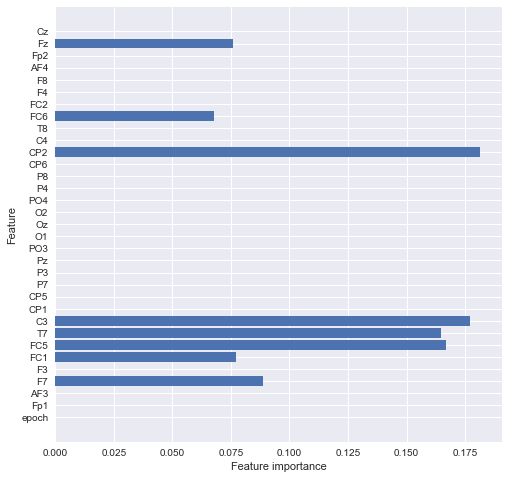

In [223]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), x.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(dtclf)

## Bag of Trees

In [224]:
# Create a BaggingClassifier
bagtree =  BaggingClassifier(DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=10), 
                                 n_estimators=20)

In [225]:
# Fit to the training data
bagtree.fit(scaled_data_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        max_depth=8,
                                                        random_state=10),
                  n_estimators=20)

In [226]:
# Predict on the test set
bt_preds = bagtree.predict(scaled_data_test)

In [227]:
print(confusion_matrix(y_test, bt_preds))
print(classification_report(y_test, bt_preds))

[[3 0 1]
 [2 0 1]
 [1 1 1]]
              precision    recall  f1-score   support

           1       0.50      0.75      0.60         4
           2       0.00      0.00      0.00         3
           4       0.33      0.33      0.33         3

    accuracy                           0.40        10
   macro avg       0.28      0.36      0.31        10
weighted avg       0.30      0.40      0.34        10



In [228]:
# Training accuracy score
bagtree.score(scaled_data_train, y_train)

1.0

In [229]:
# Test accuracy score
bagtree.score(scaled_data_test, y_test)

0.4

In [230]:
# Bag of Trees Features Importance
feature_importances = np.mean([
    tree.feature_importances_ for tree in bagtree.estimators_
], axis=0)
print(feature_importances)

[0.02722584 0.06243741 0.01022323 0.00481114 0.02182588 0.02381662
 0.05401367 0.08561547 0.04319496 0.03623427 0.02091637 0.09181205
 0.01646411 0.0223818  0.02532959 0.02424262 0.01016877 0.00830307
 0.00995851 0.00520641 0.01901896 0.00848208 0.03421143 0.00809524
 0.10314024 0.00632543 0.0673398  0.00510929 0.         0.02939914
 0.01752206 0.02642779 0.07074675]


## Random Forest Classifier

In [231]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=10, n_estimators=20)
forest.fit(scaled_data_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=20,
                       random_state=10)

In [232]:
# Make predictions for test data
y_pred_rt = forest.predict(scaled_data_test)

In [233]:
# Training accuracy score
forest.score(scaled_data_train, y_train)

1.0

In [234]:
# Test accuracy score
forest.score(scaled_data_test, y_test)

0.5

In [235]:
print(confusion_matrix(y_test, y_pred_rt))
print(classification_report(y_test, y_pred_rt))

[[2 1 1]
 [1 1 1]
 [0 1 2]]
              precision    recall  f1-score   support

           1       0.67      0.50      0.57         4
           2       0.33      0.33      0.33         3
           4       0.50      0.67      0.57         3

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.49        10
weighted avg       0.52      0.50      0.50        10



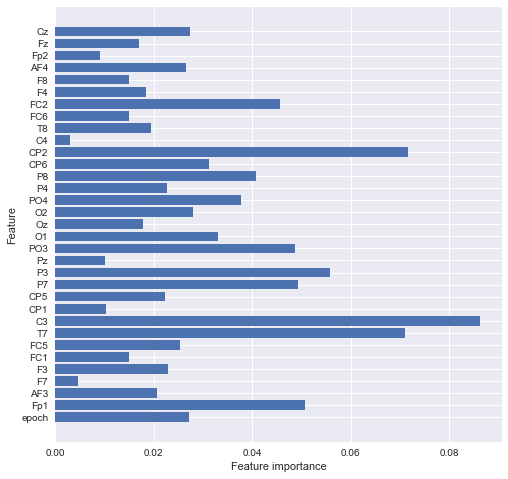

In [236]:
plot_feature_importances(forest)

## Grid Search - Decision Tree Classifier

In [237]:
dt_param_grid = {
    'class_weight': ['balanced'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [238]:
num_decision_trees = 3 * 1* 2 * 6 * 3 * 6
print(f"Grid Search will have to search through {num_decision_trees} different permutations.")

Grid Search will have to search through 648 different permutations.


In [239]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dtclf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(scaled_data_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [240]:
print(dt_grid_search.best_params_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


## Decision Tree Classifier - Hypertuned Parameters

In [241]:
# Train a DT classifier
dtclf_best = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=None, 
                                    min_samples_leaf=1, min_samples_split=2)
dtclf_best.fit(scaled_data_train, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [242]:
# Make predictions for test data
dt_best_preds = dtclf_best.predict(scaled_data_test)

In [243]:
print(confusion_matrix(y_test, dt_best_preds))
print(classification_report(y_test, dt_best_preds))

[[2 0 2]
 [0 1 2]
 [0 1 2]]
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         4
           2       0.50      0.33      0.40         3
           4       0.33      0.67      0.44         3

    accuracy                           0.50        10
   macro avg       0.61      0.50      0.50        10
weighted avg       0.65      0.50      0.52        10



In [244]:
dtclf_best.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 9.09090909e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.21590909e-01, 0.00000000e+00,
       6.79347826e-02, 0.00000000e+00, 0.00000000e+00, 1.92528736e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.33333333e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.68072680e-01, 0.00000000e+00, 1.75630468e-01, 1.11022302e-16,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

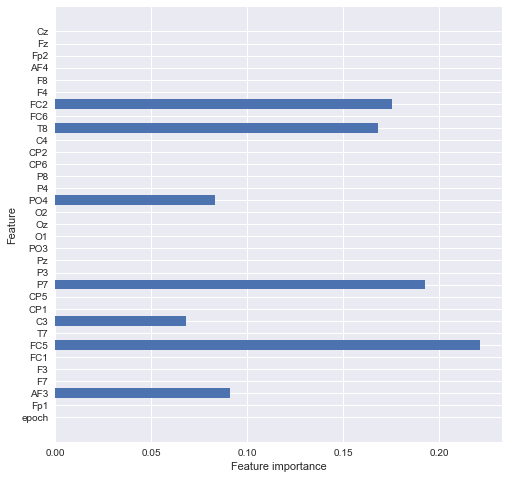

In [245]:
plot_feature_importances(dtclf_best)

## Support Vector Machines

In [246]:
svmclf = SVC(C=3, kernel='linear')
svmclf.fit(scaled_data_train, y_train)

SVC(C=3, kernel='linear')

In [247]:
svmclf.coef_

array([[-0.6006696 ,  0.18249172, -0.10689107, -0.07380049, -0.45840078,
        -0.63609647, -0.01518273,  0.08643223,  0.80680341,  0.51929251,
         0.03830767, -0.24272502,  0.16727138, -0.18092869, -0.24545057,
        -0.18771406, -0.01768782, -0.50769131, -0.46279   ,  0.14450923,
         0.45318313,  0.23332998,  0.11562335,  0.2074206 ,  0.06847828,
         0.15666683,  0.2528521 ,  0.60417974, -0.19270232, -0.04860726,
        -0.22630828,  0.24877127,  0.30870122],
       [-0.13192704,  0.35304503, -0.01529948, -0.24912617,  0.05253005,
        -0.57144821,  0.12653376, -0.14297967,  0.48333898,  0.73723772,
         0.05919276, -0.23460124,  0.63847432,  0.101151  , -0.26320435,
         0.22135493,  0.17058503, -0.47534604, -0.55148885,  0.15998478,
        -0.37374567, -0.31989251,  0.73387886,  0.05028035, -0.53714526,
         0.06674119,  0.55602985,  0.54460626, -0.36361525,  0.2025876 ,
         0.12598708,  0.02866402,  0.62739651],
       [ 0.25075605, -0.2034

In [248]:
y_pred_svm = clf.predict(scaled_data_test)

In [249]:
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

[[1 2 1]
 [1 2 0]
 [1 1 1]]
              precision    recall  f1-score   support

           1       0.33      0.25      0.29         4
           2       0.40      0.67      0.50         3
           4       0.50      0.33      0.40         3

    accuracy                           0.40        10
   macro avg       0.41      0.42      0.40        10
weighted avg       0.40      0.40      0.38        10



# 5.0 Interpreting the Results

## References

https://www.researchgate.net/publication/259768018_MEG_and_EEG_data_analysis_with_MNE-python

A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, ISSN 1662-453X, [DOI]